<a href="https://colab.research.google.com/github/Swayamprakashpatel/DD/blob/main/Conditional_VAE_Drug_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


Using device: cuda
Starting training...
--- Epoch 1/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.81it/s]


Epoch 1/100, Train Loss: 689.7815, Validation Loss: 265.7975
Validation loss improved. Saving model to best_model.pt
--- Epoch 2/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.74it/s]


Epoch 2/100, Train Loss: 253.8396, Validation Loss: 260.1969
Validation loss improved. Saving model to best_model.pt
--- Epoch 3/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.82it/s]


Epoch 3/100, Train Loss: 252.3118, Validation Loss: 260.8699
Validation loss did not improve. Patience: 1/5
--- Epoch 4/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.83it/s]


Epoch 4/100, Train Loss: 251.5194, Validation Loss: 260.9197
Validation loss did not improve. Patience: 2/5
--- Epoch 5/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.92it/s]


Epoch 5/100, Train Loss: 250.5495, Validation Loss: 258.9969
Validation loss improved. Saving model to best_model.pt
--- Epoch 6/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.94it/s]


Epoch 6/100, Train Loss: 250.4602, Validation Loss: 261.4875
Validation loss did not improve. Patience: 1/5
--- Epoch 7/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.93it/s]


Epoch 7/100, Train Loss: 251.3456, Validation Loss: 262.8319
Validation loss did not improve. Patience: 2/5
--- Epoch 8/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.86it/s]


Epoch 8/100, Train Loss: 250.2731, Validation Loss: 258.6402
Validation loss improved. Saving model to best_model.pt
--- Epoch 9/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.85it/s]


Epoch 9/100, Train Loss: 249.9694, Validation Loss: 257.8888
Validation loss improved. Saving model to best_model.pt
--- Epoch 10/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.93it/s]


Epoch 10/100, Train Loss: 249.9739, Validation Loss: 258.2702
Validation loss did not improve. Patience: 1/5
--- Epoch 11/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.88it/s]


Epoch 11/100, Train Loss: 251.1656, Validation Loss: 262.5778
Validation loss did not improve. Patience: 2/5
--- Epoch 12/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.88it/s]


Epoch 12/100, Train Loss: 249.9530, Validation Loss: 258.7560
Validation loss did not improve. Patience: 3/5
--- Epoch 13/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.87it/s]


Epoch 13/100, Train Loss: 250.0808, Validation Loss: 252.2615
Validation loss improved. Saving model to best_model.pt
--- Epoch 14/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.92it/s]


Epoch 14/100, Train Loss: 243.3347, Validation Loss: 243.8691
Validation loss improved. Saving model to best_model.pt
--- Epoch 15/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.83it/s]


Epoch 15/100, Train Loss: 238.1384, Validation Loss: 239.2787
Validation loss improved. Saving model to best_model.pt
--- Epoch 16/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.90it/s]


Epoch 16/100, Train Loss: 228.9487, Validation Loss: 234.6226
Validation loss improved. Saving model to best_model.pt
--- Epoch 17/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.91it/s]


Epoch 17/100, Train Loss: 224.6879, Validation Loss: 230.7517
Validation loss improved. Saving model to best_model.pt
--- Epoch 18/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.99it/s]


Epoch 18/100, Train Loss: 223.5139, Validation Loss: 234.1996
Validation loss did not improve. Patience: 1/5
--- Epoch 19/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.86it/s]


Epoch 19/100, Train Loss: 221.9148, Validation Loss: 229.5290
Validation loss improved. Saving model to best_model.pt
--- Epoch 20/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.80it/s]


Epoch 20/100, Train Loss: 220.2351, Validation Loss: 230.6503
Validation loss did not improve. Patience: 1/5
--- Epoch 21/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.76it/s]


Epoch 21/100, Train Loss: 205.8357, Validation Loss: 180.4476
Validation loss improved. Saving model to best_model.pt
--- Epoch 22/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.78it/s]


Epoch 22/100, Train Loss: 163.2376, Validation Loss: 155.8979
Validation loss improved. Saving model to best_model.pt
--- Epoch 23/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.87it/s]


Epoch 23/100, Train Loss: 151.7030, Validation Loss: 151.8654
Validation loss improved. Saving model to best_model.pt
--- Epoch 24/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.81it/s]


Epoch 24/100, Train Loss: 149.7808, Validation Loss: 149.0854
Validation loss improved. Saving model to best_model.pt
--- Epoch 25/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.84it/s]


Epoch 25/100, Train Loss: 147.6726, Validation Loss: 153.5390
Validation loss did not improve. Patience: 1/5
--- Epoch 26/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.89it/s]


Epoch 26/100, Train Loss: 146.3741, Validation Loss: 150.2032
Validation loss did not improve. Patience: 2/5
--- Epoch 27/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.95it/s]


Epoch 27/100, Train Loss: 146.4480, Validation Loss: 148.1743
Validation loss improved. Saving model to best_model.pt
--- Epoch 28/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.89it/s]


Epoch 28/100, Train Loss: 146.1093, Validation Loss: 155.2575
Validation loss did not improve. Patience: 1/5
--- Epoch 29/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.92it/s]


Epoch 29/100, Train Loss: 144.7198, Validation Loss: 148.8429
Validation loss did not improve. Patience: 2/5
--- Epoch 30/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.88it/s]


Epoch 30/100, Train Loss: 144.0362, Validation Loss: 146.8843
Validation loss improved. Saving model to best_model.pt
--- Epoch 31/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.64it/s]


Epoch 31/100, Train Loss: 143.7447, Validation Loss: 147.6457
Validation loss did not improve. Patience: 1/5
--- Epoch 32/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.68it/s]


Epoch 32/100, Train Loss: 142.7004, Validation Loss: 145.2394
Validation loss improved. Saving model to best_model.pt
--- Epoch 33/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.79it/s]


Epoch 33/100, Train Loss: 142.3609, Validation Loss: 147.6154
Validation loss did not improve. Patience: 1/5
--- Epoch 34/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.70it/s]


Epoch 34/100, Train Loss: 141.4599, Validation Loss: 142.8907
Validation loss improved. Saving model to best_model.pt
--- Epoch 35/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.68it/s]


Epoch 35/100, Train Loss: 141.6949, Validation Loss: 144.6898
Validation loss did not improve. Patience: 1/5
--- Epoch 36/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.67it/s]


Epoch 36/100, Train Loss: 140.9138, Validation Loss: 150.5206
Validation loss did not improve. Patience: 2/5
--- Epoch 37/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.80it/s]


Epoch 37/100, Train Loss: 140.5105, Validation Loss: 149.9910
Validation loss did not improve. Patience: 3/5
--- Epoch 38/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.71it/s]


Epoch 38/100, Train Loss: 139.9754, Validation Loss: 142.1477
Validation loss improved. Saving model to best_model.pt
--- Epoch 39/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.73it/s]


Epoch 39/100, Train Loss: 140.0387, Validation Loss: 140.5258
Validation loss improved. Saving model to best_model.pt
--- Epoch 40/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.78it/s]


Epoch 40/100, Train Loss: 139.3303, Validation Loss: 140.4829
Validation loss improved. Saving model to best_model.pt
--- Epoch 41/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.80it/s]


Epoch 41/100, Train Loss: 138.0666, Validation Loss: 141.3265
Validation loss did not improve. Patience: 1/5
--- Epoch 42/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.73it/s]


Epoch 42/100, Train Loss: 138.4691, Validation Loss: 139.1720
Validation loss improved. Saving model to best_model.pt
--- Epoch 43/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.81it/s]


Epoch 43/100, Train Loss: 137.6594, Validation Loss: 143.4871
Validation loss did not improve. Patience: 1/5
--- Epoch 44/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.77it/s]


Epoch 44/100, Train Loss: 137.8318, Validation Loss: 141.5805
Validation loss did not improve. Patience: 2/5
--- Epoch 45/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.82it/s]


Epoch 45/100, Train Loss: 137.6625, Validation Loss: 141.8927
Validation loss did not improve. Patience: 3/5
--- Epoch 46/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.67it/s]


Epoch 46/100, Train Loss: 137.2317, Validation Loss: 144.4704
Validation loss did not improve. Patience: 4/5
--- Epoch 47/100 ---


Validation: 100%|██████████| 99/99 [00:07<00:00, 13.97it/s]


Epoch 47/100, Train Loss: 137.8126, Validation Loss: 139.4465
Validation loss did not improve. Patience: 5/5
Early stopping triggered.

Training complete. Model saved to 'best_model.pt'.

Attempting to generate 5 molecules for protein sequence: MGNASNDSQSEDCETRQWLPPGESPAISSVMFSAGVLGNLIALALLARRWRGDVGCSAGRRSSLSLFHVLVTELVFTDLLGTCLISPVVLASYARNQTLVALAPESRACTYFAFAMTFFSLATMLMLFAMALERYLSIGHPYFYQRRVSRSGGLAVLPVIYAVSLLFCSLPLLDYGQYVQYCPGTWCFIRHGRTAYLQLYATLLLLLIVSVLACNFSVILNLIRMHRRSRRSRCGPSLGSGRGGPGARRRGERVSMAEETDHLILLAIMTITFAVCSLPFTIFAYMNETSSRKEKWDLQALRFLSINSIIDPWVFAILRPPVLRLMRSVLCCRISLRTQDATQTSCSTQSDASKQADL
Generated molecule (valid SMILES): CC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC)


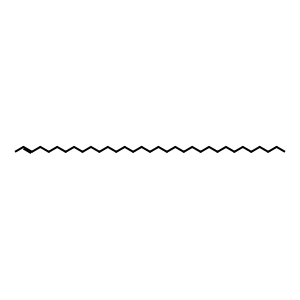

Generated molecule (invalid SMILES): CN=CC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC))))O
Generated molecule (valid SMILES): CNCCCCCCCCCCCCCCCCCCCCCC


[11:54:46] SMILES Parse Error: extra close parentheses while parsing: CN=CC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC))))O
[11:54:46] SMILES Parse Error: check for mistakes around position 38:
[11:54:46] CCCCCCCCCCCCCCCCCCCC))))O
[11:54:46] ~~~~~~~~~~~~~~~~~~~~^
[11:54:46] SMILES Parse Error: Failed parsing SMILES 'CN=CC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC))))O' for input: 'CN=CC=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC))))O'


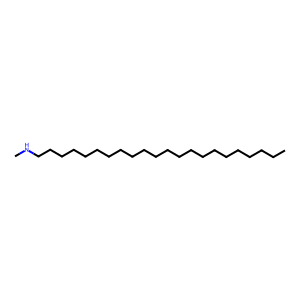

Generated molecule (invalid SMILES): COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC)
Generated molecule (invalid SMILES): CC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


[11:54:46] SMILES Parse Error: extra close parentheses while parsing: COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC)
[11:54:46] SMILES Parse Error: check for mistakes around position 56:
[11:54:46] CCCCCCCCCCCCCCCCCCCC)
[11:54:46] ~~~~~~~~~~~~~~~~~~~~^
[11:54:46] SMILES Parse Error: Failed parsing SMILES 'COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC)' for input: 'COCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC)'
[11:54:46] SMILES Parse Error: extra open parentheses while parsing: CC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[11:54:46] SMILES Parse Error: check for mistakes around position 3:
[11:54:46] CC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
[11:54:46] ~~^
[11:54:46] SMILES Parse Error: Failed parsing SMILES 'CC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' for input: 'CC(=CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import MolToImage
from IPython.display import Image, display
import numpy as np
import warnings
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

# Suppress RDKit warnings for a cleaner output
warnings.filterwarnings("ignore")

# --- Global constants for SMILES tokenization ---
# This dictionary has been updated to include a padding character '`'
# which is used to ensure all SMILES strings have a consistent length.
SMILES_TOKEN_DICT = {
    '#': 0, '(': 1, ')': 2, '+': 3, '-': 4, '/': 5, '=': 6, '[': 7, ']': 8,
    'C': 9, 'c': 10, 'H': 11, 'N': 12, 'O': 13, 'S': 14, 'F': 15, 'I': 16,
    'P': 17, 'n': 18, 's': 19, 'B': 20, 'Cl': 21, 'Br': 22, 'r': 23, 'l': 24,
    'o': 25, 'p': 26, 'se': 27, 'Se': 28, 'a': 29, 'i': 30, '`': 31
}

SMILES_MAX_LEN = 1000
HIDDEN_DIM = 256
LATENT_DIM = 64
NUM_LAYERS = 2
MAX_EPOCHS = 100
BATCH_SIZE = 64
PATIENCE = 5
LEARNING_RATE = 1e-3
MODEL_SAVE_PATH = 'best_model.pt'

# --- Data Preprocessing and PyTorch Dataset ---

def smiles_to_one_hot(smiles, max_len=SMILES_MAX_LEN):
    """Encodes a SMILES string into a one-hot vector with padding."""
    token_to_idx = SMILES_TOKEN_DICT
    if len(smiles) > max_len:
        # Truncate and add end-of-string token
        smiles = smiles[:max_len-1] + '`'
    else:
        # Pad with end-of-string token
        smiles += '`' * (max_len - len(smiles))

    one_hot_vector = np.zeros((max_len, len(token_to_idx)))
    for i, token in enumerate(list(smiles)):
        if token in token_to_idx:
            one_hot_vector[i, token_to_idx[token]] = 1
    return one_hot_vector

def get_protein_embedding(seq):
    """
    A simple, placeholder protein embedding function.
    In a real-world scenario, you would use a more sophisticated method,
    like a pre-trained protein language model.
    """
    protein_vocab = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10,
                     'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}
    embedding = np.zeros(len(protein_vocab))
    for amino_acid in seq:
        if amino_acid in protein_vocab:
            embedding[protein_vocab[amino_acid]] = 1
    return embedding

class SmilesProteinDataset(Dataset):
    """Dataset for loading SMILES and Protein sequence pairs."""
    def __init__(self, smiles_list, protein_list):
        self.smiles_list = smiles_list
        self.protein_list = protein_list
        # The protein embedding dimension is determined from the first sequence in the list
        self.protein_embedding_dim = len(get_protein_embedding(self.protein_list[0]))

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        protein = self.protein_list[idx]
        smiles_one_hot = smiles_to_one_hot(smiles)
        protein_embedding = get_protein_embedding(protein)
        return torch.tensor(smiles_one_hot, dtype=torch.float32), torch.tensor(protein_embedding, dtype=torch.float32)

# --- Conditional VAE Model Definition ---

class ConditionalVAE(nn.Module):
    def __init__(self, smiles_vocab_size, protein_embedding_dim, hidden_dim, latent_dim, smiles_max_len, num_layers):
        super(ConditionalVAE, self).__init__()

        self.smiles_max_len = smiles_max_len
        self.smiles_vocab_size = smiles_vocab_size
        self.protein_embedding_dim = protein_embedding_dim

        # Encoder: takes smiles and protein embedding as input
        self.encoder_rnn = nn.GRU(
            input_size=smiles_vocab_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.encoder_protein_mlp = nn.Sequential(
            nn.Linear(protein_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: takes latent vector and protein embedding as input
        self.decoder_gru_input_mlp = nn.Sequential(
            nn.Linear(latent_dim + protein_embedding_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder_rnn = nn.GRU(
            input_size=smiles_vocab_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc_output = nn.Linear(hidden_dim, smiles_vocab_size)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from N(mu, var)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encoder(self, smiles_one_hot, protein_embedding):
        _, hidden_smiles = self.encoder_rnn(smiles_one_hot)
        hidden_protein = self.encoder_protein_mlp(protein_embedding).unsqueeze(0).repeat(hidden_smiles.size(0), 1, 1)
        combined_hidden = hidden_smiles + hidden_protein
        final_hidden_state = combined_hidden[-1, :, :]
        mu = self.fc_mu(final_hidden_state)
        logvar = self.fc_logvar(final_hidden_state)
        return mu, logvar

    def decoder(self, z, protein_embedding):
        z_with_protein = torch.cat((z, protein_embedding), dim=1)
        initial_hidden = self.decoder_gru_input_mlp(z_with_protein).unsqueeze(0)
        initial_hidden = initial_hidden.repeat(self.decoder_rnn.num_layers, 1, 1)
        decoder_input = torch.zeros(z.size(0), self.smiles_max_len, self.smiles_vocab_size).to(z.device)
        decoder_input[:, 0, SMILES_TOKEN_DICT['#']] = 1
        output, _ = self.decoder_rnn(decoder_input, initial_hidden)
        output = self.fc_output(output)
        return output

    def forward(self, smiles_one_hot, protein_embedding):
        mu, logvar = self.encoder(smiles_one_hot, protein_embedding)
        z = self.reparameterize(mu, logvar)
        reconstructed_smiles = self.decoder(z, protein_embedding)
        return reconstructed_smiles, mu, logvar

# --- Training Loop and Generation ---

def vae_loss(recon_x, x, mu, logvar):
    """VAE loss function: BCE + KL divergence."""
    # Ensure dimensions are compatible for BCE calculation
    recon_x_flat = recon_x.view(-1, len(SMILES_TOKEN_DICT))
    x_flat = x.view(-1, len(SMILES_TOKEN_DICT))
    BCE = nn.functional.binary_cross_entropy_with_logits(recon_x_flat, x_flat, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_model(model, dataloader, optimizer, device):
    """Trains the VAE model for one epoch with a progress bar."""
    model.train()
    total_loss = 0

    for smiles_oh, protein_emb in tqdm(dataloader, desc="Training"):
        smiles_oh = smiles_oh.to(device)
        protein_emb = protein_emb.to(device)

        optimizer.zero_grad()

        reconstructed_smiles, mu, logvar = model(smiles_oh, protein_emb)
        loss = vae_loss(reconstructed_smiles, smiles_oh, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

def validate_model(model, dataloader, device):
    """Evaluates the model on the validation set."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for smiles_oh, protein_emb in tqdm(dataloader, desc="Validation"):
            smiles_oh = smiles_oh.to(device)
            protein_emb = protein_emb.to(device)

            reconstructed_smiles, mu, logvar = model(smiles_oh, protein_emb)
            loss = vae_loss(reconstructed_smiles, smiles_oh, mu, logvar)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

def generate_new_molecules(model, protein_seq, num_molecules=5, device="cpu"):
    """Generates and visualizes new molecules for a given protein sequence."""
    model.eval()
    idx_to_token = {v: k for k, v in SMILES_TOKEN_DICT.items()}
    generated_molecules = []

    # Prepare the protein embedding for a single sequence
    protein_embedding = get_protein_embedding(protein_seq)
    protein_embedding = torch.tensor(protein_embedding, dtype=torch.float32).unsqueeze(0).to(device)

    print(f"\nAttempting to generate {num_molecules} molecules for protein sequence: {protein_seq}")
    with torch.no_grad():
        for i in range(num_molecules):
            # Sample a vector from the latent space
            z = torch.randn(1, LATENT_DIM).to(device)
            # Use the decoder to generate a one-hot encoded SMILES string
            generated_output = model.decoder(z, protein_embedding)

            # Use softmax to get probabilities for each token and then select the most likely one
            probabilities = nn.functional.softmax(generated_output, dim=-1)
            predicted_indices = torch.argmax(probabilities, dim=-1).squeeze(0).cpu().numpy()

            generated_smiles = ""
            for token_idx in predicted_indices:
                token = idx_to_token.get(token_idx, '')
                # Stop decoding when a padding token is encountered
                if token == '`':
                    break
                generated_smiles += token

            # Validate and display the generated SMILES string as an image
            mol = Chem.MolFromSmiles(generated_smiles)
            if mol is not None:
                print(f"Generated molecule (valid SMILES): {generated_smiles}")
                img = MolToImage(mol)
                display(img)
            else:
                print(f"Generated molecule (invalid SMILES): {generated_smiles}")

            generated_molecules.append(generated_smiles)

    return generated_molecules

if __name__ == '__main__':
    # Determine the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define an example protein sequence to predict for
    target_protein_sequence = 'MGNASNDSQSEDCETRQWLPPGESPAISSVMFSAGVLGNLIALALLARRWRGDVGCSAGRRSSLSLFHVLVTELVFTDLLGTCLISPVVLASYARNQTLVALAPESRACTYFAFAMTFFSLATMLMLFAMALERYLSIGHPYFYQRRVSRSGGLAVLPVIYAVSLLFCSLPLLDYGQYVQYCPGTWCFIRHGRTAYLQLYATLLLLLIVSVLACNFSVILNLIRMHRRSRRSRCGPSLGSGRGGPGARRRGERVSMAEETDHLILLAIMTITFAVCSLPFTIFAYMNETSSRKEKWDLQALRFLSINSIIDPWVFAILRPPVLRLMRSVLCCRISLRTQDATQTSCSTQSDASKQADL'

    # --- Training Process ---
    try:
        df = pd.read_csv('final_output_15_2_25.csv')
        smiles_list = df['SMILES'].tolist()
        protein_list = df['TARGET_SEQUENCE'].tolist()
    except FileNotFoundError:
        print("Error: The data file 'final_output_15_2_25.csv' was not found. Please ensure it is uploaded.")
        exit()

    # Create dataset and dataloader
    full_dataset = SmilesProteinDataset(smiles_list, protein_list)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize the model and optimizer
    protein_embedding_dim = len(get_protein_embedding(target_protein_sequence))
    model = ConditionalVAE(
        smiles_vocab_size=len(SMILES_TOKEN_DICT),
        protein_embedding_dim=protein_embedding_dim,
        hidden_dim=HIDDEN_DIM,
        latent_dim=LATENT_DIM,
        smiles_max_len=SMILES_MAX_LEN,
        num_layers=NUM_LAYERS
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = float('inf')
    patience_counter = 0

    print("Starting training...")
    for epoch in range(MAX_EPOCHS):
        print(f"--- Epoch {epoch+1}/{MAX_EPOCHS} ---")
        train_loss = train_model(model, train_dataloader, optimizer, device)
        val_loss = validate_model(model, val_dataloader, device)

        print(f"Epoch {epoch+1}/{MAX_EPOCHS}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Check for improvement and save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"Validation loss improved. Saving model to {MODEL_SAVE_PATH}")
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{PATIENCE}")

        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

    print(f"\nTraining complete. Model saved to '{MODEL_SAVE_PATH}'.")

    # --- Generation Process ---
    # We load the best model to ensure we are using the one with the best performance
    best_model = ConditionalVAE(
        smiles_vocab_size=len(SMILES_TOKEN_DICT),
        protein_embedding_dim=protein_embedding_dim,
        hidden_dim=HIDDEN_DIM,
        latent_dim=LATENT_DIM,
        smiles_max_len=SMILES_MAX_LEN,
        num_layers=NUM_LAYERS
    ).to(device)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    # Generate new molecules using the loaded model
    generate_new_molecules(best_model, target_protein_sequence, num_molecules=5, device=device)
